In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [2]:
load_dotenv()

True

In [9]:
generationPrompt=ChatPromptTemplate.from_messages(
    messages=[
                (
                    "system",
                    """You are a twitter techie influencer assistant tasked with writing excellent twitter posts
                    Generate the best twitter post accessible for the user's request
                    If the user provides critique, respond with a revised version of your attempts"""
                ),
                MessagesPlaceholder(variable_name="messages")
            ]
)

In [6]:
reflectionPrompt=ChatPromptTemplate.from_messages(
    messages=[
                (
                    "system",
                    """You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet
                    Always provide detailed recommendations, including requests for length, virality, style, etc."""
                ),
                MessagesPlaceholder(variable_name="messages"),
             ]
            )

In [7]:
llmGemini=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")
llmOpenAI=ChatOpenAI(model="gpt-4o-mini",temperature=0.5)

In [10]:
generationChain=generationPrompt|llmOpenAI

In [11]:
reflectionChain=reflectionPrompt|llmOpenAI

In [12]:
graph=MessageGraph()

In [13]:
REFLECT="reflect"

In [14]:
GENERATE="generate"

In [15]:
def generateNode(state):
    return generationChain.invoke(input={"messages":state})

In [16]:
def reflectNode(state):
    response=reflectionChain.invoke(input={"messages":state})
    # let the agent get tricked into believing that the message came from human
    return [HumanMessage(content=response.content)]
   

In [17]:
graph.add_node(node=GENERATE,action=generateNode)

In [18]:
graph.add_node(node=REFLECT,action=reflectNode)

In [19]:
graph.set_entry_point(key=GENERATE)

In [20]:
def should_continue(state):
    if len(state) >4:
        return "end"
    else:
        return "reflect"

In [21]:
# the should continue is path is a conditional path which is established through this function
graph.add_conditional_edges(
    source=GENERATE,
    path=should_continue,
    path_map={"end":END, "reflect":REFLECT},
    ) 

In [22]:
graph.add_edge(start_key=REFLECT,end_key=GENERATE)

In [23]:
app=graph.compile()

In [24]:
print(app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	generate(generate)
	reflect(reflect)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate;
	generate -.-> reflect;
	reflect --> generate;
	generate -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



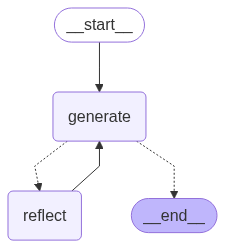

In [25]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png(max_retries=3)))

In [26]:
app.get_graph().print_ascii()

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
          +----------+             
          | generate |             
          +----------+             
          ***        ...           
         *              .          
       **                ..        
+---------+           +---------+  
| reflect |           | __end__ |  
+---------+           +---------+  


In [27]:
prompt="AI agents taking over content creation"

In [28]:
response=app.invoke(input=HumanMessage(content=prompt))

In [29]:
response

[HumanMessage(content='AI agents taking over content creation', additional_kwargs={}, response_metadata={}, id='4450a479-4ca5-4d76-9d28-73d2b56cd78c'),
 AIMessage(content='🚀 AI agents are revolutionizing content creation! From writing engaging articles to generating stunning visuals, they’re enhancing creativity and efficiency. 🌟 Embrace the future of storytelling where humans and AI collaborate to produce remarkable content! #AI #ContentCreation #Innovation', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 59, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-Bwioy6YMwZD53ydNtU90xZFmxqyse', 'finish_reason': 'stop', 'logprobs': None}, id='run--e79b1160-371a-4633-a9

In [30]:
response[-1].content

'Thanks for the valuable feedback! Here’s an updated version of the tweet that incorporates your suggestions:\n\n🤖✨ AI agents like ChatGPT and DALL-E are transforming content creation! Imagine collaborating with these tools to craft stunning stories and visuals. How do you see AI changing the way we create? Share your thoughts! #AI #ContentCreation #Innovation\n\nThis version includes specific examples of AI tools to provide context. If you have any trending hashtags in mind or any other adjustments, let me know!'